In [1]:
from brainmri.dataset.stacker import MriStacker
from brainmri.dataset.dataset import *
from brainmri.models.arch import UNet
from brainmri.runner.train import train_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import albumentations as A
from albumentations.pytorch import ToTensor
import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

In [2]:
config = {
     'make_stacks': True,
     'stack_size': 3,
     'data_dir': './data/lgg-mri-segmentation/kaggle_3m/',
     'out_dir': './data/lgg-mri-segmentation/2.5D/StackSize=3',
     'model_out_pth': './models/unet-scratch_aug_{date}.pth',
     'augmentations': True,
     'epochs': 300,
     'batch_size': 64,
     'lr': 1e-04,
     'optimizer': 'adam',
     'device': 'cuda',
     'num_classes': 1
}

In [3]:
A.__version__

'0.2.3'

In [4]:
def get_augmentations(is_train, apply_transforms=False):
    if is_train and not apply_transforms:
        print("apply_transforms is False. Augmentations not applied")
        
    return A.Compose([
        A.RandomCrop(width = 128, height = 128, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

        # Pixels
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
        A.IAAEmboss(p=0.25),
        A.Blur(p=0.01, blur_limit = 3),

        # Affine
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
        ToTensor()
    ])

In [5]:
stacker = MriStacker(root_dir=config.get("data_dir"),
                         out_dir=config.get("out_dir"),
                         stack_size=config.get("stack_size"))

if config.get("make_stacks"):
    stacker.process_patients()

stacker.gen_train_val_test_split()

augs = get_augmentations(is_train=True, apply_transforms=config.get("augmentations"))
train_ds = BrainMriSegmentation(stacker.train_df, config.get("stack_size"),
                                transforms=get_augmentations(is_train=True, apply_transforms=config.get("augmentations")),
                                preprocessing=None)
valid_ds = BrainMriSegmentation(stacker.valid_df, config.get("stack_size"),
                                transforms=A.Compose([ToTensor()]), preprocessing=None)

train_dl = get_dataloader(train_ds, bs=config.get("batch_size"))
valid_dl = get_dataloader(valid_ds, bs=config.get("batch_size"))


model = UNet(3)

optimizer = torch.optim.Adam(model.parameters(), lr=config.get("lr"))

if torch.cuda.device_count() > 1 and config.get("device") == "cuda":
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model = model.cuda()

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5), smp.utils.metrics.Fscore(threshold=0.5)]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=config.get("device"),
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=config.get("device"),
    verbose=True
)

train_loss, valid_loss, train_fscore, valid_fscore, train_iou, valid_iou = [], [], [], [], [], []

max_score = 0
for i in range(0, config.get("epochs")):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dl)
    valid_logs = valid_epoch.run(valid_dl)

    if max_score < valid_logs["fscore"]:
        max_score = valid_logs["fscore"]
        torch.save(model, config.get("model_out_pth").format(date=str(date.today())))
        print("Model saved!")

    train_loss.append(train_logs["dice_loss"])
    valid_loss.append(valid_logs["dice_loss"])
    train_fscore.append(train_logs["fscore"])
    valid_fscore.append(valid_logs["fscore"])
    train_iou.append(train_logs["iou_score"])
    valid_iou.append(valid_logs["iou_score"])  



Let's use 2 GPUs!

Epoch: 0
valid: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, dice_loss - 0.659, iou_score - 0.2167, fscore - 0.3499]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s, dice_loss - 0.6315, iou_score - 0.2284, fscore - 0.3687]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s, dice_loss - 0.6463, iou_score - 0.2207, fscore - 0.3537]

Epoch: 3
valid: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s, dice_loss - 0.6081, iou_score - 0.2475, fscore - 0.3924]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s, dice_loss - 0.6044, iou_score - 0.2538, fscore - 0.3957]
Model saved!

Epoch: 5
valid: 100%|██████████| 10/10 [00:05<00:00,  2.33it/s, dice_loss - 0.5661, iou_score - 0.2823, fscore - 0.4339]
Model saved!

Epoch: 6
valid: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s, dice_loss - 0.5804, iou_score - 0.2732, fscore - 0.4197]

Epoch: 7
valid: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s,

valid: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s, dice_loss - 0.3614, iou_score - 0.475, fscore - 0.6386]
Model saved!

Epoch: 35
valid: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, dice_loss - 0.3521, iou_score - 0.4875, fscore - 0.6481]
Model saved!

Epoch: 36
valid: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, dice_loss - 0.3734, iou_score - 0.4584, fscore - 0.6266]

Epoch: 37
valid: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, dice_loss - 0.3951, iou_score - 0.437, fscore - 0.6062]

Epoch: 38
valid: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, dice_loss - 0.3356, iou_score - 0.4997, fscore - 0.6646]
Model saved!

Epoch: 39
valid: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s, dice_loss - 0.3938, iou_score - 0.4461, fscore - 0.6066]

Epoch: 40
valid: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s, dice_loss - 0.3498, iou_score - 0.4883, fscore - 0.6506]

Epoch: 41
valid: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, dice_loss - 0.3585, iou_score - 0.4793, fscore 

valid: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, dice_loss - 0.3234, iou_score - 0.531, fscore - 0.6767]

Epoch: 69
valid: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s, dice_loss - 0.2745, iou_score - 0.5717, fscore - 0.7261]
Model saved!

Epoch: 70
valid: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s, dice_loss - 0.2572, iou_score - 0.5931, fscore - 0.7429]
Model saved!

Epoch: 71
valid: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, dice_loss - 0.2932, iou_score - 0.548, fscore - 0.7068]

Epoch: 72
valid: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, dice_loss - 0.2951, iou_score - 0.5469, fscore - 0.7053]

Epoch: 73
valid: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s, dice_loss - 0.2801, iou_score - 0.5636, fscore - 0.7201]

Epoch: 74
valid: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, dice_loss - 0.2754, iou_score - 0.5711, fscore - 0.7257]

Epoch: 75
valid: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s, dice_loss - 0.2834, iou_score - 0.5602, fscore - 0.7169]

Ep

valid: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, dice_loss - 0.2821, iou_score - 0.567, fscore - 0.718] 

Epoch: 103
valid: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, dice_loss - 0.2329, iou_score - 0.6262, fscore - 0.7672]
Model saved!

Epoch: 104
valid: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, dice_loss - 0.2341, iou_score - 0.6246, fscore - 0.7661]

Epoch: 105
valid: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s, dice_loss - 0.2357, iou_score - 0.6203, fscore - 0.7646]

Epoch: 106
valid: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s, dice_loss - 0.2189, iou_score - 0.6429, fscore - 0.7814]
Model saved!

Epoch: 107
valid: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s, dice_loss - 0.2176, iou_score - 0.6466, fscore - 0.7827]
Model saved!

Epoch: 108
valid: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, dice_loss - 0.2371, iou_score - 0.6221, fscore - 0.763]

Epoch: 109
valid: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s, dice_loss - 0.2425, iou_score - 0.6107, 

valid: 100%|██████████| 10/10 [00:04<00:00,  1.89it/s, dice_loss - 0.2086, iou_score - 0.6586, fscore - 0.7917]

Epoch: 137
valid: 100%|██████████| 10/10 [00:03<00:00,  2.23it/s, dice_loss - 0.2224, iou_score - 0.6418, fscore - 0.7779]

Epoch: 138
valid: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, dice_loss - 0.1896, iou_score - 0.684, fscore - 0.8107]
Model saved!

Epoch: 139
valid: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, dice_loss - 0.1882, iou_score - 0.6845, fscore - 0.8122]
Model saved!

Epoch: 140
valid: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s, dice_loss - 0.2142, iou_score - 0.6499, fscore - 0.786]

Epoch: 141
valid: 100%|██████████| 10/10 [00:03<00:00,  2.45it/s, dice_loss - 0.1918, iou_score - 0.6802, fscore - 0.8085]

Epoch: 142
valid: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s, dice_loss - 0.1925, iou_score - 0.6781, fscore - 0.8078]

Epoch: 143
valid: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s, dice_loss - 0.2079, iou_score - 0.6569, fscore - 0.79

valid: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s, dice_loss - 0.1634, iou_score - 0.7206, fscore - 0.8368]

Epoch: 171
valid: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s, dice_loss - 0.1763, iou_score - 0.7051, fscore - 0.8239]

Epoch: 172
valid: 100%|██████████| 10/10 [00:04<00:00,  3.28it/s, dice_loss - 0.1696, iou_score - 0.7111, fscore - 0.8309]

Epoch: 173
valid: 100%|██████████| 10/10 [00:04<00:00,  1.96it/s, dice_loss - 0.1665, iou_score - 0.7162, fscore - 0.8336]

Epoch: 174
valid: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s, dice_loss - 0.1429, iou_score - 0.7514, fscore - 0.8574]
Model saved!

Epoch: 175
valid: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, dice_loss - 0.1635, iou_score - 0.7204, fscore - 0.8366]

Epoch: 176
valid: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s, dice_loss - 0.1566, iou_score - 0.7315, fscore - 0.8437]

Epoch: 177
valid: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s, dice_loss - 0.1531, iou_score - 0.7363, fscore - 0.8471]

Epoch:

valid: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, dice_loss - 0.1485, iou_score - 0.7432, fscore - 0.8515]

Epoch: 206
valid: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s, dice_loss - 0.1438, iou_score - 0.7495, fscore - 0.8564]

Epoch: 207
valid: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, dice_loss - 0.1629, iou_score - 0.7215, fscore - 0.8375]

Epoch: 208
valid: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, dice_loss - 0.149, iou_score - 0.7422, fscore - 0.8512]

Epoch: 209
valid: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s, dice_loss - 0.1534, iou_score - 0.7358, fscore - 0.8469]

Epoch: 210
valid: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, dice_loss - 0.1631, iou_score - 0.721, fscore - 0.8373]

Epoch: 211
valid: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, dice_loss - 0.1758, iou_score - 0.7064, fscore - 0.8245]

Epoch: 212
valid: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s, dice_loss - 0.1602, iou_score - 0.7244, fscore - 0.84] 

Epoch: 213
valid: 100%

valid: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s, dice_loss - 0.1284, iou_score - 0.7731, fscore - 0.8717]
Model saved!

Epoch: 240
valid: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, dice_loss - 0.1374, iou_score - 0.7595, fscore - 0.8628]

Epoch: 241
valid: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, dice_loss - 0.1431, iou_score - 0.7504, fscore - 0.8571]

Epoch: 242
valid: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s, dice_loss - 0.1307, iou_score - 0.7702, fscore - 0.8695]

Epoch: 243
valid: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s, dice_loss - 0.1358, iou_score - 0.7621, fscore - 0.8644]

Epoch: 244
valid: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s, dice_loss - 0.1544, iou_score - 0.7356, fscore - 0.8457]

Epoch: 245
valid: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s, dice_loss - 0.1537, iou_score - 0.7346, fscore - 0.8465]

Epoch: 246
valid: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s, dice_loss - 0.145, iou_score - 0.7495, fscore - 0.8552]

Epoch: 

valid: 100%|██████████| 10/10 [00:04<00:00,  2.56it/s, dice_loss - 0.1221, iou_score - 0.7839, fscore - 0.8782]
Model saved!

Epoch: 275
valid: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, dice_loss - 0.1244, iou_score - 0.7795, fscore - 0.8758]

Epoch: 276
valid: 100%|██████████| 10/10 [00:03<00:00,  2.26it/s, dice_loss - 0.1401, iou_score - 0.7552, fscore - 0.8601]

Epoch: 277
valid: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s, dice_loss - 0.1269, iou_score - 0.7758, fscore - 0.8733]

Epoch: 278
valid: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s, dice_loss - 0.1399, iou_score - 0.7555, fscore - 0.8603]

Epoch: 279
valid: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s, dice_loss - 0.1303, iou_score - 0.7705, fscore - 0.8698]

Epoch: 280
valid: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, dice_loss - 0.1347, iou_score - 0.7631, fscore - 0.8653]

Epoch: 281
valid: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s, dice_loss - 0.1322, iou_score - 0.7671, fscore - 0.8679]

Epoch:

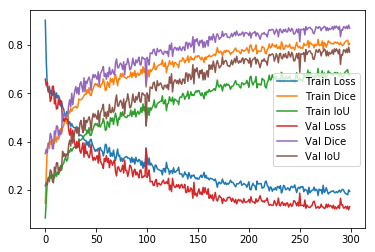

In [6]:
plt.plot(train_loss)
plt.plot(train_fscore)
plt.plot(train_iou)
plt.plot(valid_loss)
plt.plot(valid_fscore)
plt.plot(valid_iou)                                                                                

plt.legend(["Train Loss",  "Train Dice", "Train IoU", "Val Loss", "Val Dice", "Val IoU"])

In [7]:
best_model = torch.load("./models/unet-scratch_aug_2021-08-26.pth")

In [8]:
test_ds = BrainMriSegmentation(stacker.test_df, config.get("stack_size"),
                                transforms=A.Compose([ToTensor()]))
test_dl = get_dataloader(test_ds, bs=config.get("batch_size"))

In [9]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5), smp.utils.metrics.Fscore(threshold=0.5)]
    
test_epoch =  smp.utils.train.ValidEpoch(
    best_model,
    loss=loss,
    metrics=metrics,
    device=config.get("device"),
    verbose=True
)

In [10]:
test_epoch.run(test_dl)

valid: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s, dice_loss - 0.1431, iou_score - 0.7508, fscore - 0.8569]


{'dice_loss': 0.14310375849405926,
 'iou_score': 0.7507843573888143,
 'fscore': 0.8568852047125498}